存图片 max_0001.png, dart_0001.png      
存坐标 max_coord.txt, dart_coord.txt    
u-y方向, v-x方向

In [122]:
import pickle
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import time

def get_partion_uvp_list(psnr_index_file, partion=0.0001):
    with open(psnr_index_file, 'rb') as _f:
        index_psnr = pickle.load(_f) # (N,3)
    length = index_psnr.shape[0]
    partion = int(length*partion)
    print(partion)
    uvp_list = index_psnr[:partion, :] # (p,3)
    
    return uvp_list

def save_uv_images(img, uvp_list, save_folder, patch_size, prefix="max"):
    coord = ""
    for i, uvp in enumerate(tqdm(uvp_list)):
        u = int(uvp[1])
        v = int(uvp[0])
        print(uvp)
        patch = img[u:u+patch_size, v:v+patch_size]
        img_name = prefix + "_" + str(i).rjust(5,"0") + ".png"
        img_save_path = os.path.join(save_folder, img_name)
        imageio.imwrite(img_save_path, patch)
        coord = coord + "{} {} {} {}\n".format(u,v,patch_size,patch_size)
    
    txt_name = prefix + "_coord.txt"
    txt_save_path = os.path.join(save_folder, txt_name)
    with open(txt_save_path,'w',encoding='utf-8') as f:
        f.write(coord)

def is_in_list(uv, darts_list):
    ''' whether uv is in th darts_list
        uv np.(2,)  darts_list np.(n,2)'''

    return (darts_list == uv).all(axis=1).any(axis=0)

def samplePatchesProg(img_dim, patch_size, n_samples, maxiter=5):
    # Sample patches using dart throwing (works well for sparse/non-overlapping patches)

    # estimate each sample patch area
    full_area = float(img_dim[0] * img_dim[1])
    sample_area = full_area / n_samples

    # get corresponding dart throwing radius
    radius = np.sqrt(sample_area / np.pi)
    minsqrdist = (2 * radius) ** 2

    # compute the distance to the closest patch
    def get_sqrdist(x, y, patches):
        if len(patches) == 0:
            return np.infty
        dist = patches - [x, y]
        return np.sum(dist ** 2, axis=1).min()

    # perform dart throwing, progressively reducing the radius
    rate = 0.96
    patches = np.zeros((n_samples, 2), dtype=int)
    xmin, xmax = 0, img_dim[1] - patch_size[1] - 1
    ymin, ymax = 0, img_dim[0] - patch_size[0] - 1
    for patch in tqdm(range(n_samples)):
        done = False
        while not done:
            for i in range(maxiter):
                x = random.randint(xmin, xmax)
                y = random.randint(ymin, ymax)
                sqrdist = get_sqrdist(x, y, patches[:patch, :])
                if sqrdist > minsqrdist:
                    patches[patch, :] = [x, y]
                    done = True
                    break
            if not done:
                radius *= rate
                minsqrdist = (2 * radius) ** 2

    return patches

def gen_map(file):
    with open(file, 'rb') as _f:
        index_psnr = pickle.load(_f) # (N,3)
    index_psnr = np.array(index_psnr)
    # print(index_psnr.shape)
    x = index_psnr[:,0]
    y = index_psnr[:,1]
    x_max = int(x.max())
    y_max = int(y.max())
    # print(x_max)
    # print(y_max)
    heatmap = np.empty((y_max+1,x_max+1))
    for i in range(index_psnr.shape[0]):
        yi = int(index_psnr[i][0])
        xi = int(index_psnr[i][1])
        heatmap[xi][yi] = index_psnr[i][2]
    return heatmap

def prunePatches(shape, patches, patchsize, imp):
    pruned = np.empty_like(patches)

    # Generate a set of regions tiling the image using snake ordering.
    def get_regions_list(shape, step):
        regions = []
        for y in range(0, shape[0], step):
            if y // step % 2 == 0:
                xrange = range(0, shape[1], step)
            else:
                xrange = reversed(range(0, shape[1], step))
            for x in xrange:
                regions.append((x, x + step, y, y + step))
        return regions

    # Split 'patches' in current and remaining sets, where 'cur' holds the
    # patches in the requested region, and 'rem' holds the remaining patches.
    def split_patches(patches, region):
        cur = np.empty_like(patches)
        rem = np.empty_like(patches)
        ccount, rcount = 0, 0
        for i in range(patches.shape[0]):
            x, y = patches[i, 0], patches[i, 1]
            if region[0] <= x < region[1] and region[2] <= y < region[3]:
                cur[ccount, :] = [x, y]
                ccount += 1
            else:
                rem[rcount, :] = [x, y]
                rcount += 1
        return cur[:ccount, :], rem[:rcount, :]

    # Process all patches, region by region, pruning them randomly according to
    # their importance value, ie. patches with low importance have a higher
    # chance of getting pruned. To offset the impact of the binary pruning
    # decision, we propagate the discretization error and take it into account
    # when pruning.
    rem = np.copy(patches)
    count, error = 0, 0
    for region in get_regions_list(shape, 4 * patchsize):
        cur, rem = split_patches(rem, region)
        for i in range(cur.shape[0]):
            x, y = cur[i, 0], cur[i, 1]
            if imp[y, x] - error > random.random():
                pruned[count, :] = [x, y]
                count += 1
                error += 1 - imp[y, x]
            else:
                error += 0 - imp[y, x]

    return pruned[:count, :]

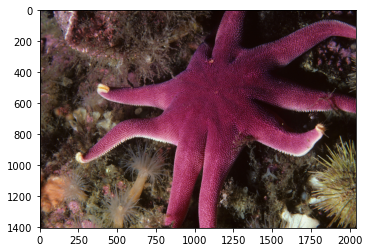

In [101]:
'''define parameters and show original hr image'''

import imageio
import matplotlib.pyplot as plt

scale = 2
patch_size_hr = 192
patch_size_lr = patch_size_hr // scale
img_index = "0001"
partion = 0.0001

img_file_lr = "/data/shizun/dataset/DIV2K/DIV2K_train_LR_bicubic/X2/{}x2.png".format(img_index)
img_file_hr = "/data/shizun/dataset/DIV2K/DIV2K_train_HR/{}.png".format(img_index)

img_hr = imageio.imread(img_file_hr)
plt.imshow(img_hr)

In [9]:
''' uvp_list'''

psnr_file = "/data/shizun/dataset/DIV2K/bin/DIV2K_train_LR_bicubic/X2/{}x2_psnr_np.pt".format(img_index)
uvp_list = get_partion_uvp_list(psnr_file, partion=partion)
uvp_list_hr = uvp_list[:,:2]*scale
# uvp_list

56


In [10]:
'''save max'''

import os

prefix = "max"
save_folder = "./uv_images/{}/".format(img_index) + prefix
os.makedirs(save_folder, exist_ok=True)

save_uv_images(img_hr, uvp_list_hr, save_folder, patch_size_hr, prefix)

100%|██████████| 56/56 [00:00<00:00, 96.67it/s]


(702, 1020)
100%|██████████| 1000/1000 [00:00<00:00, 11886.90it/s]
(1000, 2)



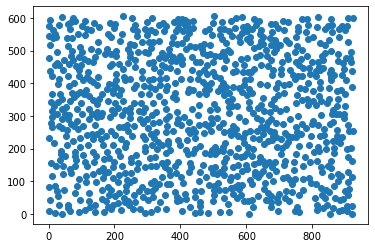

In [11]:
''' throwing darts'''

img_dim_lr = (img_hr.shape[0]//scale, img_hr.shape[1]//scale)
print(img_dim_lr, flush=True)

n_samples = 1000
darts_list = samplePatchesProg(img_dim_lr, (patch_size_lr,patch_size_lr), n_samples)

print("\n{}".format(darts_list.shape), flush=True)

# plt.figure(figsize=(15, 10))
plt.scatter(list(a[0] for a in darts_list), list(a[1] for a in darts_list))
plt.show()

In [123]:
''' darts_uvp_list'''

heatmap = gen_map(psnr_file)

darts_uvp = []
for i in range(darts_list.shape[0]):
    darts_u = darts_list[i,1]
    darts_v = darts_list[i,0]
    darts_psnr = heatmap[darts_u,darts_v]
    darts_uvp.append([darts_v,darts_u,darts_psnr])

darts_uvp = sorted(darts_uvp, key=lambda a: a[2], reverse=False) # sorted by psnr (N,3)

n_partion = int((img_dim_lr[0]-patch_size_lr)*(img_dim_lr[1]-patch_size_lr)*partion)
darts_uvp_partion = darts_uvp[:n_partion]
darts_uvp_list = np.array(darts_uvp_partion)
darts_uvp_list_hr = darts_uvp_list[:,:2]*scale
# darts_uvp_partion
heatmap = 1/heatmap

[[ 356 1024]
 [ 504 1100]
 [ 538  980]
 [ 794 1090]
 [ 842 1004]
 [ 322 1128]
 [ 434  946]
 [ 810  894]
 [ 752  964]
 [ 588 1058]
 [ 426 1162]
 [ 706 1130]
 [ 894  852]
 [ 694  530]
 [ 288  972]
 [ 362 1218]
 [ 498  890]
 [ 552 1190]
 [ 246 1182]
 [ 672  920]
 [ 658  628]
 [ 946 1038]
 [ 578  846]
 [ 474 1250]
 [1094 1014]
 [ 722  402]
 [ 646 1228]
 [ 976  916]
 [ 760 1196]
 [ 204 1098]
 [ 402 1310]
 [1010  812]
 [ 774  328]
 [ 628  754]
 [ 380  860]
 [ 290 1270]
 [ 716  820]
 [ 924 1720]
 [ 684 1350]
 [1038 1078]
 [ 636  468]
 [ 444 1450]
 [ 828  262]
 [ 588 1290]
 [ 900 1124]
 [ 842  784]
 [ 458  798]
 [ 208 1314]
 [1066  876]
 [ 754  590]
 [ 734 1422]
 [1104  774]
 [ 176 1424]
 [ 476 1560]
 [ 552  706]
 [ 136 1150]
 [1028 1754]
 [ 330 1360]
 [ 596  566]
 [ 236  904]
 [ 942  748]
 [1154  954]
 [ 864 1780]
 [ 780  726]
 [ 988 1664]
 [ 140 1522]
 [1190 1052]
 [1192  722]
 [ 778 1502]
 [ 880  194]
 [ 806 1842]
 [ 516 1648]
 [ 998  422]
 [1128 1118]
 [ 796  490]
 [ 532 1374]
 [ 162 1014]

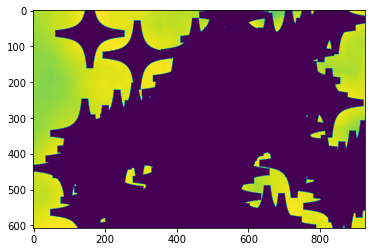

In [124]:
threshold = 0.05
n_nms = 100

# generate nms mask
nms_mask = np.ones((patch_size_lr*2+1,patch_size_lr*2+1))
center = (patch_size_lr,patch_size_lr)
for iy in range(nms_mask.shape[0]):
    for ix in range(nms_mask.shape[1]):
        I = np.abs((iy - center[0]) * (ix - center[1])) # intersection
        U = 2*np.power(patch_size_lr,2) - I       # Union
        iou = I/U
        # print(iou)
        if iou < threshold:
            nms_mask[iy][ix] = 0
plt.imshow(nms_mask)
# print(heatmap.shape)
selected_list = []

tic = time.time()
for i in range(n_nms):
    selected = np.unravel_index(heatmap.argmax(), heatmap.shape)
    x1 = max(0, selected[1]-patch_size_lr)
    x2 = min(heatmap.shape[1], selected[1] + patch_size_lr+1)
    y1 = max(0, selected[0]-patch_size_lr)
    y2 = min(heatmap.shape[0], selected[0] + patch_size_lr+1)
    # print(x1,x2,y1,y2)
    # print(heatmap[y1:y2,x1:x2].shape)
    x3 = max(0, patch_size_lr - selected[1])
    x4 = min(patch_size_lr*2+1, heatmap.shape[1]-selected[1]+patch_size_lr)
    y3 = max(0, patch_size_lr - selected[0])
    y4 = min(patch_size_lr*2+1, heatmap.shape[0]-selected[0]+patch_size_lr)
    # print(x3,x4,y3,y4)
    # print(nms_mask[y3:y4,x3:x4].shape)
    heatmap[y1:y2,x1:x2] = nms_mask[y3:y4,x3:x4]*heatmap[y1:y2,x1:x2]

    selected_list.append(selected)
    # break

selected_list = scale * np.array(selected_list)
uvp
# print(selected_list)
toc = time.time()
t = toc - tic
print("time: {:.3f}".format(t))
plt.imshow(heatmap)


# pad = patch_size_lr // 2
# pruned = np.maximum(0, prunePatches((img_dim_lr[0]-350,img_dim_lr[1]-350), darts_list + pad, patch_size_lr, heatmap) - pad)
# # plt.figure(figsize=(15, 10))
# plt.scatter(list(a[0] for a in pruned), list(a[1] for a in pruned))
# plt.show()

In [125]:
'''save darts'''

import os

prefix = "nms"
save_folder = "./uv_images/{}/".format(img_index) + prefix
os.makedirs(save_folder, exist_ok=True)

n_partion = img_dim_lr[0]*img_dim_lr[1]*partion
# save_uv_images(img_hr, darts_uvp_list_hr, save_folder, patch_size_hr, prefix)
save_uv_images(img_hr, nms_uvp_list_hr, save_folder, patch_size_hr, prefix)

  7%|▋         | 7/100 [00:00<00:01, 67.03it/s][ 356 1024]
[ 504 1100]
[538 980]
[ 794 1090]
[ 842 1004]
[ 322 1128]
[434 946]
[810 894]
[752 964]
[ 588 1058]
[ 426 1162]
[ 706 1130]
[894 852]
[694 530]
[288 972]
 22%|██▏       | 22/100 [00:00<00:01, 69.59it/s][ 362 1218]
[498 890]
[ 552 1190]
[ 246 1182]
[672 920]
[658 628]
[ 946 1038]
[578 846]
[ 474 1250]
[1094 1014]
[722 402]
[ 646 1228]
[976 916]
[ 760 1196]
[ 204 1098]
 37%|███▋      | 37/100 [00:00<00:00, 73.15it/s]
[ 402 1310]
[1010  812]
[774 328]
[628 754]
[380 860]
[ 290 1270]
[716 820]
[ 924 1720]


ValueError: tile cannot extend outside image